In [1]:
import numpy as np
import json
import os
import h5py
import seaborn as sns
import cmasher as cmr
import scipy.io as sio
import patchworklib as pw
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy import stats
import matplotlib.image as mpimg
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
import matplotlib.gridspec as gridspec


<Figure size 100x100 with 0 Axes>

In [2]:
maskroot='result/masks.mat'
acc_lw='result/LW/'
acc_al='result/AL/'
filter_path='result/filter_visualization'
RC_params='result/RC_Params'
feat_corr='result/feat_corr/'
top_images_path = 'result/imagenet_top/'
recunstruction_path="result/recunstruction/"

In [3]:
atlases = sio.loadmat(maskroot)
indx1 = atlases['indx1'] #number of voxels in each visual area per subject(v,s)
indx2 = atlases['indx2'] #cumulative number of voxels per subject
indx3 = atlases['indx3'] #number of voxels in each area

In [4]:
def flatten(l):
    return [item for sublist in l for item in sublist]

def plot_rf_as_circles(rfs):
    for rf in rfs:
        c = plt.Circle((rf[1], rf[2]), rf[0],  fill=False, alpha=1, lw=2.,color='rosybrown')
        plt.gca().add_artist(c)
    plt.xlim([-10,10])
    plt.ylim([-10,10])
    plt.xticks([-10,10], fontsize=20)
    plt.yticks([-10,10], fontsize=20)
    plt.xlabel('x (degree)', labelpad=-10, fontsize=20)
    plt.ylabel('y (degree)', labelpad=-40, fontsize=20)
    plt.gca().set_aspect('equal')


In [5]:
ROI=['v1','v2','v3','v4','LO','MT','FFA','PPA','EBA','RSC']
subjects=['vim2/subject1','vim2/subject2','vim2/subject3','purdue/subject1','purdue/subject2','purdue/subject3']


In [6]:
#lW ACC


model=['UC','SC','DC','RC']
layer=['L1','L2','L3','L4','L5','L6','L7','L8']

#concatenate
if not os.path.exists('result/layer_stats.json'):
    S_LW=[]

    for s in range (len(subjects)):
        S_LW_=np.zeros((int(indx2[-1,s]),len(model),len(layer)));
        for m in range (0,len(model)):
            for l in range (0, len(layer)):
                S_LW_[:,m,l]=h5py.File(f"{acc_lw}{subjects[s]}_{layer[l]}_{model[m]}.mat",'r')['/acc'][:]
        S_LW.append(S_LW_) 

    V_LW =[]
    for i in range(len(ROI)):     
        V_LW__=np.zeros((indx3[0][i],len(model),len(layer)));
        for m in range (0,len(model)):
            for l in range (0,len(layer)):
                V_LW_=[]
                for s in range (len(subjects)):
                    if i==0:
                        V_LW_.append(S_LW[s][0:indx2[0,s],m,l])
                    else:
                        V_LW_.append(S_LW[s][indx2[i-1,s]:indx2[i,s],m,l])
                V_LW__[:,m,l]=flatten(V_LW_)           
        V_LW.append(V_LW__)        


    # remove nan
    for i in range (len(V_LW)):
        V_LW[i] = V_LW[i][~np.isnan(V_LW[i], where=True)].reshape([-1,len(model),len(layer)])

    V_mean_LW=np.zeros((len(ROI),len(model),len(layer)))
    V_std_LW=np.zeros((len(ROI),len(model),len(layer)))

    # mean and std
    for i in range (len(ROI)):
        V_mean_LW[i,:]=np.mean(V_LW[i],axis=0)
        V_std_LW[i,:]=np.std(V_LW[i],axis=0)


    #select layer   
    V_mean_LW1=np.array([V_mean_LW[0,:,2],V_mean_LW[1,:,2],V_mean_LW[2,:,3],V_mean_LW[3,:,3],V_mean_LW[4,:,5]\
               ,V_mean_LW[5,:,5],V_mean_LW[6,:,7],V_mean_LW[7,:,6],V_mean_LW[8,:,6],V_mean_LW[9,:,4]])
    V_std_LW1=np.array([V_std_LW[0,:,2],V_std_LW[1,:,2],V_std_LW[2,:,3],V_std_LW[3,:,3],V_std_LW[4,:,5]\
               ,V_std_LW[5,:,5],V_std_LW[6,:,7],V_std_LW[7,:,6],V_std_LW[8,:,6],V_std_LW[9,:,4]])



    dict_={}
    dict_["V_mean_LW1"] = V_mean_LW1.tolist()
    dict_["V_std_LW1"] = V_std_LW1.tolist()

    for i in range (len(ROI)):
        mean=[];std=[];ste=[];var=[]
        for l in range (len(layer)):
            tmp=V_LW[i][:,1:len(ROI),:][:,:,l]
            tmp_=flatten(tmp)
            mean_=np.mean(tmp_)
            std_=np.std(tmp_)
            mean.append(mean_)
            std.append(std_)
            ste_=stats.sem(tmp_)
            ste.append(ste_)
            var.append(np.square(std_))


        dict_[f"{ROI[i]}_mean"]=mean
        dict_[f"{ROI[i]}_std"]=std
        dict_[f"{ROI[i]}_ste"]=ste
        dict_[f"{ROI[i]}_var"]=var


        with open('result/layer_stats.json','w') as f:
            json.dump(dict_,f)





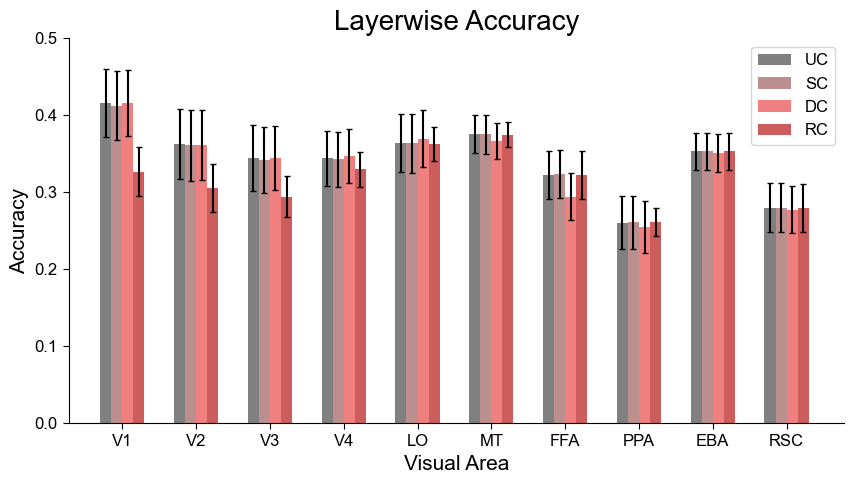

In [7]:
#LW ACC

with open('result/layer_stats.json', 'r') as fp:
    data = json.load(fp)
V_mean_LW1 = np.array(data['V_mean_LW1'])
V_std_LW1 = np.array(data['V_std_LW1'])

fig = plt.figure(figsize=(10,5))
Col=['gray','rosybrown','lightcoral','indianred','firebrick','darkred']
N = len(ROI)
ind = np.arange(N)
width = 0.15 

for i in range (0,len(model)):
    plt.bar(ind+(i*width),V_mean_LW1[:,i],width =width,color=Col[i], yerr=V_std_LW1[:,i],capsize=2)
    
plt.subplot().spines['right'].set_visible(False)
plt.subplot().spines['top'].set_visible(False)
plt.xlabel('Visual Area', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Layerwise Accuracy', fontsize=20)
plt.xticks(ind+(1.5*width),['V1','V2','V3','V4','LO','MT','FFA','PPA','EBA','RSC'])
plt.legend((model),loc='upper right')
plt.axis([-0.5, 10, 0, 0.5])
plt.show()

([<matplotlib.axis.YTick at 0x1eab87f0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

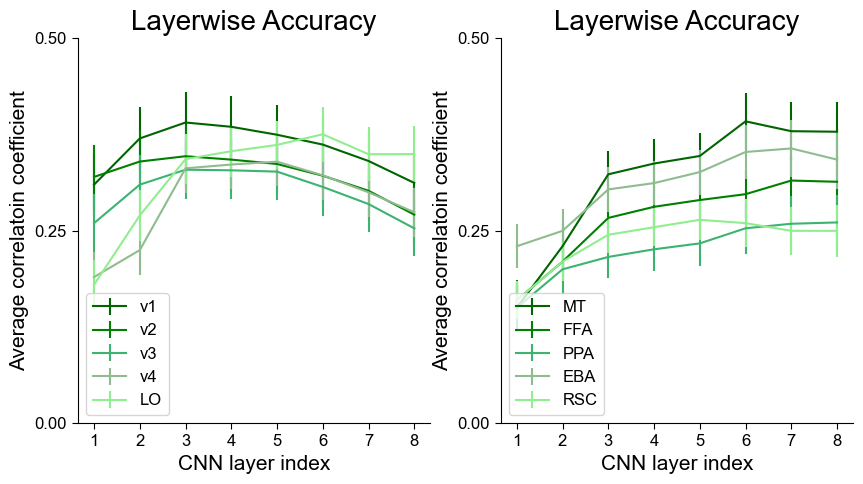

In [8]:
fig = plt.figure(figsize=(10,5))
color =["darkgreen","green","mediumseagreen","darkseagreen","lightgreen"] 
layer=['L1','L2','L3','L4','L5','L6','L7','L8']

with open('result/layer_stats.json', 'r') as fp:
    data = json.load(fp)


plt.subplot(1,2,1)
plt.subplot(1,2,1).spines['right'].set_visible(False)
plt.subplot(1,2,1).spines['top'].set_visible(False)
for i in range(5):
    plt.errorbar(np.arange(len(layer)),data[f'{ROI[i]}_mean'],yerr=data[f'{ROI[i]}_std'],color=color[i])
plt.ylim([0,.50])
plt.xlabel('CNN layer index', fontsize=15)
plt.ylabel('Average correlatoin coefficient', fontsize=15)
plt.title('Layerwise Accuracy', fontsize=20)
plt.xticks(np.arange(0,8),np.arange(1,9))
plt.legend(ROI[0:5],loc='lower left')
plt.yticks([0,0.25,0.5])


plt.subplot(1,2,2)
plt.subplot(1,2,2).spines['right'].set_visible(False)
plt.subplot(1,2,2).spines['top'].set_visible(False)
for i in range(5,10):
    plt.errorbar(np.arange(len(layer)),data[f'{ROI[i]}_mean'],yerr=data[f'{ROI[i]}_std'],color=color[i-5])
plt.ylim([0,.50])
plt.xlabel('CNN layer index', fontsize=15)
plt.ylabel('Average correlatoin coefficient', fontsize=15)
plt.title('Layerwise Accuracy', fontsize=20)
plt.xticks(np.arange(0,8),np.arange(1,9))
plt.legend(ROI[5:10],loc='lower left')
plt.yticks([0,0.25,0.5])


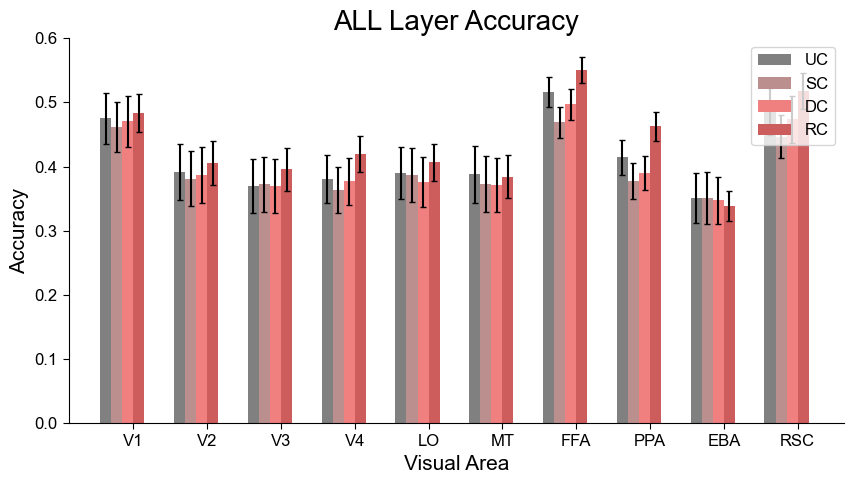

In [9]:
fig = plt.figure(figsize=(10,5))
ROI=['v1','v2','v3','v4','LO','MT','FFA','PPA','EBA','RSC']
Col=['gray','rosybrown','lightcoral','indianred','firebrick','darkred']


with open('result/all_stats.json', 'r') as fp:
    data = json.load(fp)
V_mean_AL = np.array(data['V_mean_AL'])
V_std_AL = np.array(data['V_std_AL'])

N = 10
ind = np.arange(N)
width = 0.15 
for i in range (0,len(model)):
    plt.bar(ind+(i*width),V_mean_AL[:,i],width =width,color=Col[i], yerr=V_std_AL[:,i],capsize=2)

plt.subplot().spines['right'].set_visible(False)
plt.subplot().spines['top'].set_visible(False)
plt.xlabel('Visual Area', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('ALL Layer Accuracy', fontsize=20)
plt.xticks(ind+(2.5*width),['V1','V2','V3','V4','LO','MT','FFA','PPA','EBA','RSC'])
plt.legend((model),loc='upper right')
plt.axis([-0.5, 10, 0, 0.6])
plt.show()

In [10]:
# ALL layer acc

model=['UC','SC','DC','RC','SRC','DRC']

ROI=['v1','v2','v3','v4','LO','MT','FFA','PPA','EBA','RSC']

if not os.path.exists('result/all_stats.json'):
    
    S_AL=[]
    for s in range (len(subjects)):
        S_AL_=np.zeros((int(indx2[-1,s]),len(model)));
        for m in range (0,len(model)):
            S_AL_[:,m]=h5py.File(f"{acc_al}{subjects[s]}_{model[m]}.mat",'r')['/acc'][:]
        S_AL.append(S_AL_) 

    V_AL =[]
    for i in range(len(ROI)):     
        V_AL__=np.zeros((indx3[0][i],len(model)));
        for m in range (len(model)):
            V_AL_=[]
            for s in range (len(subjects)):
                if i==0:
                    V_AL_.append(S_AL[s][0:indx2[0,s],m])
                else:
                    V_AL_.append(S_AL[s][indx2[i-1,s]:indx2[i,s],m])
            V_AL__[:,m]=flatten(V_AL_)           
        V_AL.append(V_AL__)        


    # remove nan
    for i in range (len(V_AL)):
        V_AL[i] = V_AL[i][~np.isnan(V_AL[i], where=True)].reshape([-1,len(model)])

    V_mean_AL=np.zeros((len(ROI),len(model)))
    V_std_AL=np.zeros((len(ROI),len(model)))

    for i in range (len(ROI)):
        V_mean_AL[i,:]=np.mean(V_AL[i],axis=0)
        V_std_AL[i,:]=np.std(V_AL[i],axis=0)
        
    dict_={}
    dict_["V_mean_AL"] = V_mean_AL.tolist()
    dict_["V_std_AL"] = V_std_AL.tolist()


        
    with open('result/all_stats.json','w') as f:
        json.dump(dict_,f)





Text(0.5, 1.0, 'Layer contribution to prediction accuracy')

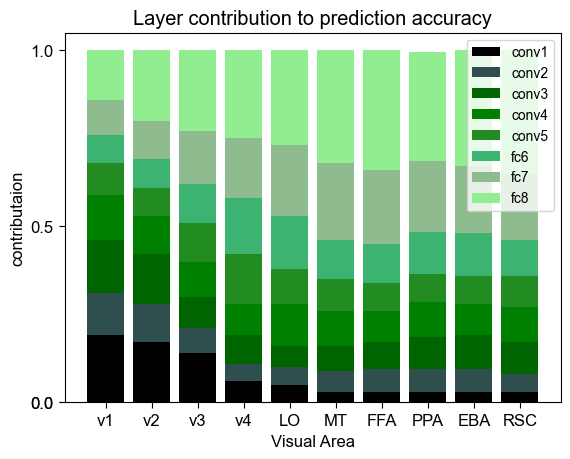

In [11]:
color =["black","darkslategrey","darkgreen","green","forestgreen","mediumseagreen","darkseagreen","lightgreen"] 
layer_cont=sio.loadmat('result/layercontribution.mat')['layer_cont']
layer=['conv1','conv2','conv3','conv4','conv5','fc6','fc7','fc8']
for j in range(len(layer_cont)):
    for i in range(len(layer)):
        plt.bar(j,layer_cont[j][i],bottom=sum(layer_cont[j][:i]),color=color[i])
plt.xticks(np.arange(len(ROI)),["v1","v2","v3","v4","LO","MT","FFA","PPA","EBA","RSC"])
plt.yticks([0, 0.5, 0, 1])
plt.legend(layer,loc='upper right',prop={'size': 10})
plt.xlabel('Visual Area')
plt.ylabel('contributaion')
plt.title('Layer contribution to prediction accuracy')

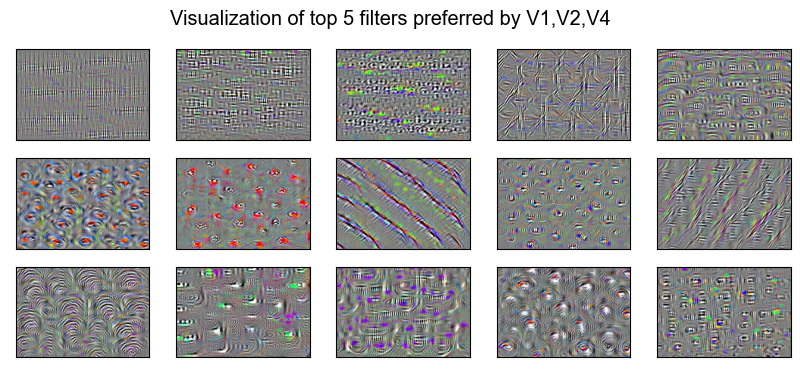

In [12]:
#filter visualization
fig = plt.figure(figsize=(10,4))

fil = sio.loadmat("result/filter_index.mat")['fil']

fig.suptitle("Visualization of top 5 filters preferred by V1,V2,V4")
for r in range (len(fil)):
    for j in range (len(fil[r])):
        
        plt.subplot(3,5,r*5+j+1) 
        plt.xticks([]);plt.yticks([])
        if r<=1:
            img = mpimg.imread(f"{filter_path}/conv3/{int(fil[r][j])}.jpg")
        if r>1:
            img = mpimg.imread(f"{filter_path}/conv4/{int(fil[r][j])}.jpg")
        plt.imshow(img,aspect='auto')
        



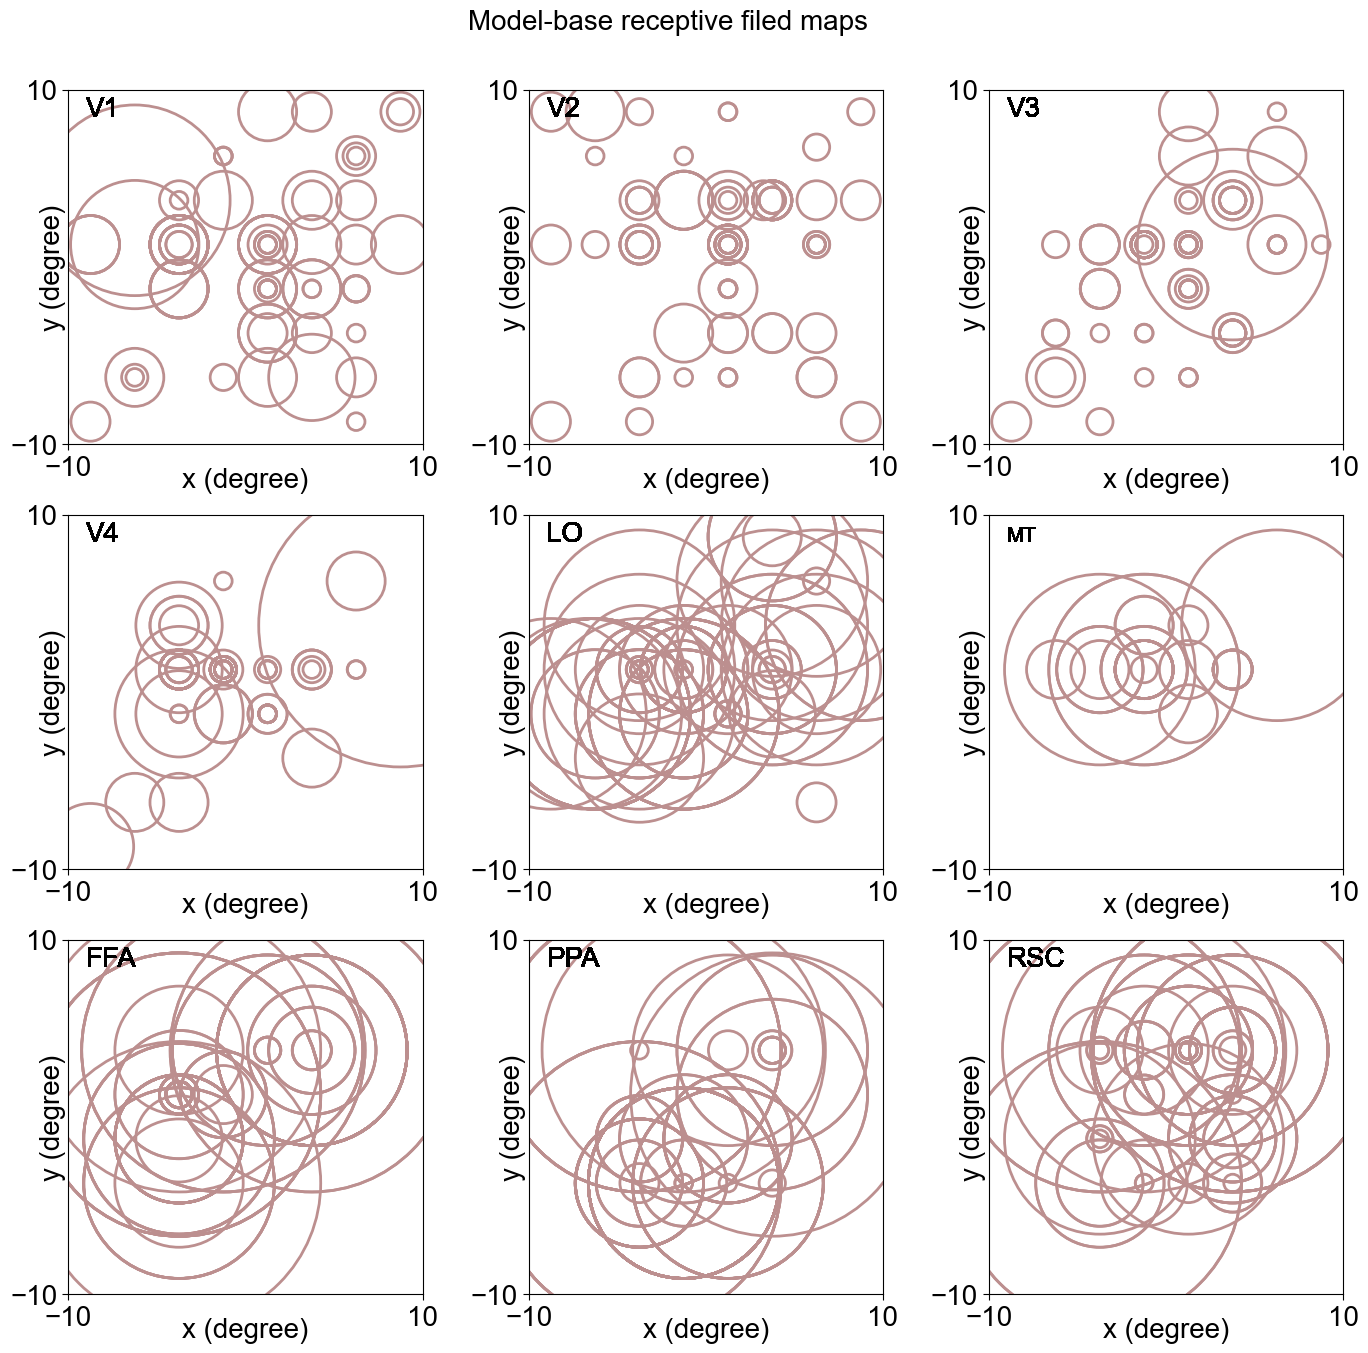

In [13]:
fig = plt.figure(figsize=(15,15))
fig.suptitle("Model-base receptive filed maps",fontsize=20)

ROI=[u'v1',u'v2',u'v3',u'v4',u'v5',u'v6',u'v7',u'v8',u'v10']
roi=['V1','V2','V3','V4','LO','MT','FFA','PPA','RSC']
for r in range (0,9):
    plt.subplot(3,3,r+1)  
    
    rfs=h5py.File(f"{RC_params}/sub4_RC_{ROI[r]}.mat",'r')[ROI[r]]                  
                        
    for i in range (len(rfs[0])):
            plot_rf_as_circles([rfs[:,i]])
            plt.text(-9, 8.5, roi[r], horizontalalignment='left', fontsize=20,)
            plt.subplots_adjust(left=.1, bottom=.1, right=.95, top=.95, wspace=.3, hspace=0.) 
plt.show()


In [14]:
#rf params:Vim_2 acc, r, x, y
ROI=[u'v1',u'v2',u'v3',u'v4',u'v5',u'v6',u'v7',u'v8',u'v9',u'v10'] 
rad=np.zeros([len(ROI),len(subjects)]) 
rad_std=np.zeros([len(ROI),len(subjects)]) 
cent=np.zeros([len(ROI),len(subjects)])
cent_std=np.zeros([len(ROI),len(subjects)]) 

for r in range (0,len(ROI)):
    for s in range(0,6):
            try:
                rfs=h5py.File(f"{RC_params}/sub{str(s+1)}_RC_{ROI[r]}.mat", 'r')[ROI[r]] 
                rad[r,s]=np.mean(rfs[0,:])  
                
                rad_std=np.std(rfs[0,:]) 
                cent[r,s]=np.mean(np.sqrt(np.multiply(rfs[1],rfs[1])+np.multiply(rfs[2],rfs[2])))
                cent_std[r,s]=np.std(np.sqrt(np.multiply(rfs[1],rfs[1])+np.multiply(rfs[2],rfs[2])))
            except:
                rad[r,s] = 'nan'
                cent[r,s] = 'nan'




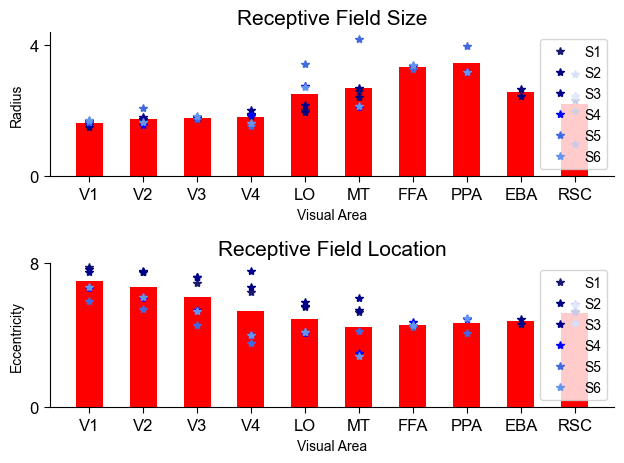

In [15]:

subjects = ['S1','S2','S3','S4','S5','S6']
col = ['midnightblue','navy','darkblue','blue','royalblue','cornflowerblue']

N = 10
ind = np.arange(N)
width = 0.15 

plt.subplot(2,1,1)
plt.subplot(2,1,1).spines['right'].set_visible(False)
plt.subplot(2,1,1).spines['top'].set_visible(False)
plt.xlabel('Visual Area', fontsize=10)
plt.ylabel('Radius', fontsize=10)
plt.title('Receptive Field Size', fontsize=15)
plt.xticks(ind,['V1','V2','V3','V4','LO','MT','FFA','PPA','EBA','RSC'])
plt.yticks([0,4])

for i in range (len(subjects)):
    plt.plot(ind,rad[:,i],'*',color=col[i])

plt.bar(ind,np.nanmean(rad,1),width = .5,color='red',)
plt.legend(subjects,loc='upper right',prop={'size': 10})



plt.subplot(2,1,2)
plt.subplot(2,1,2).spines['right'].set_visible(False)
plt.subplot(2,1,2).spines['top'].set_visible(False)
plt.xlabel('Visual Area', fontsize=10)
plt.ylabel('Eccentricity', fontsize=10)
plt.title('Receptive Field Location', fontsize=15)
plt.xticks(ind,['V1','V2','V3','V4','LO','MT','FFA','PPA','EBA','RSC'])
plt.ylim([0,8]);plt.yticks([0,8])

for i in range (len(subjects)):
    plt.plot(ind,cent[:,i],'*',color=col[i])
    
plt.bar(ind,np.nanmean(cent,1),width = .5,color='red',)
plt.legend(subjects,loc='upper right',prop={'size': 10})

plt.tight_layout()

plt.show()




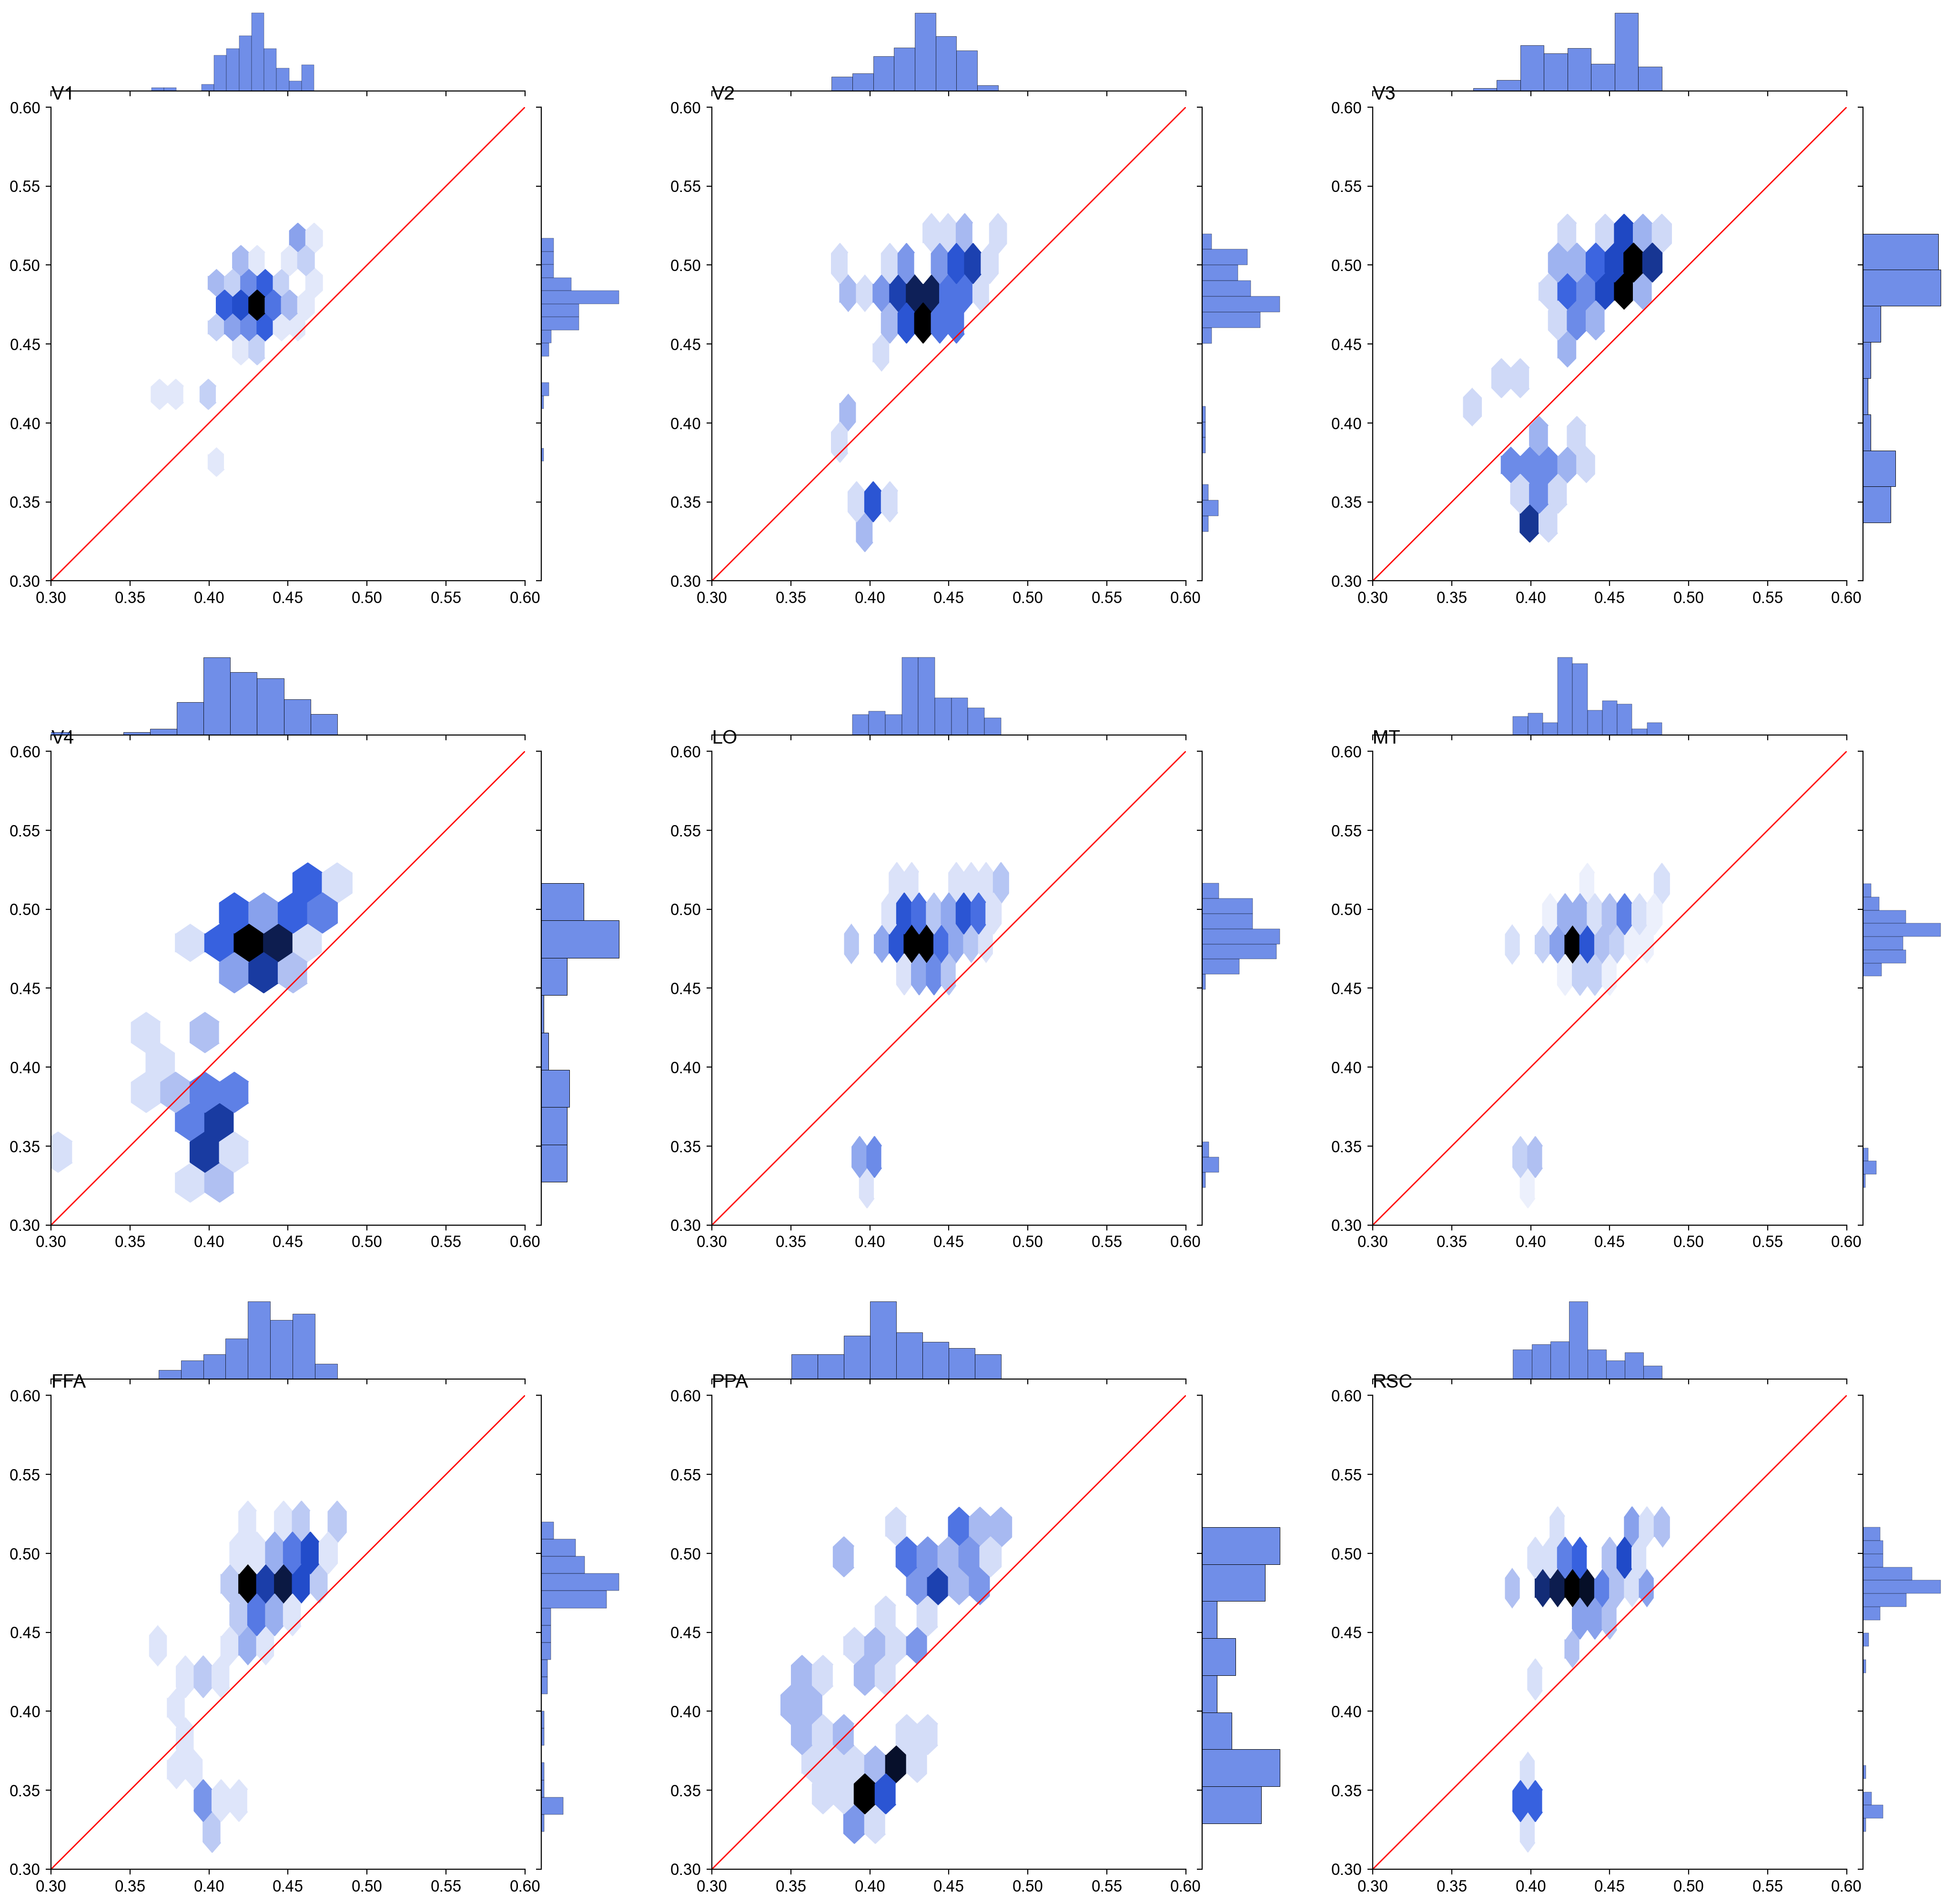

In [16]:
 
pw.overwrite_axisgrid() 
#filter visualization

ROI=[u'V1',u'V2',u'V3',u'V4',u'LO',u'MT',u'FFA',u'PPA',u'RSC']
roi=['V1','V2','V3','V4','LO','MT','FFA','PPA','RSC']

A=[None]*9
for r in range (0,9):
    a_UC=[]
    a_SC=[]
    V_UC=h5py.File(f'{feat_corr}{ROI[r]}_UC.mat','r')['/correlation_UC'][:]
    a_UC=np.concatenate((a_UC,V_UC.squeeze()))
    V_SC=h5py.File(f'{feat_corr}{ROI[r]}_SC.mat','r')['/correlation_SC'][:]
    a_SC=np.concatenate((a_SC,V_SC.squeeze()))
    A[r] = sns.jointplot(x=a_UC, y=a_SC, color = 'royalblue', kind='hex', joint_kws= dict(gridsize=10), marginal_ticks= False, xlim=[0.3,0.6], ylim=[0.3,0.6]);
    A[r].ax_joint.plot([0.3,0.6], [0.3,0.6], 'r-', linewidth = 1)
    A[r].ax_joint.set_title(f"{ROI[r]}",loc='left')
    A[r] = pw.load_seaborngrid(A[r], label=f"A{r}")



(A[0]|A[1]|A[2])/(A[3]|A[4]|A[5])/(A[6]|A[7]|A[8])


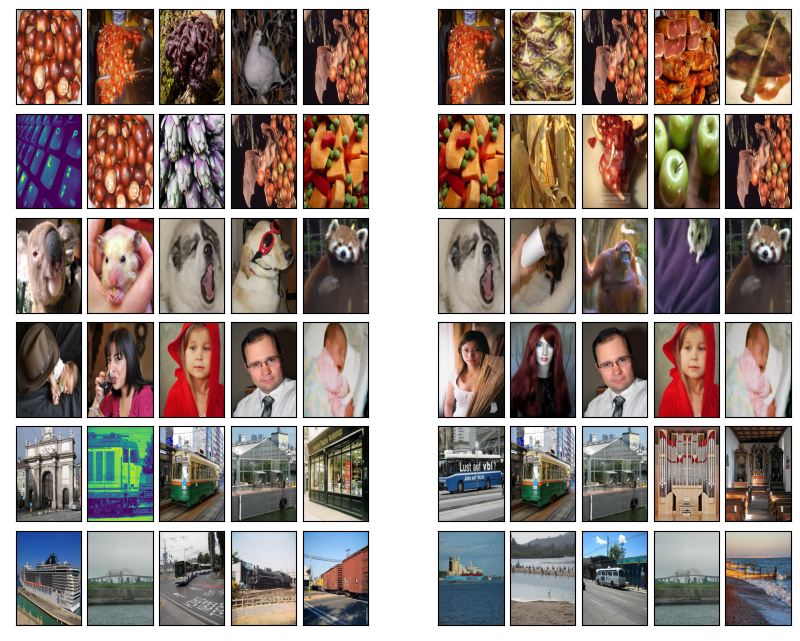

In [18]:
ROI = ['V1','V2','V4','FFA','PPA','RSC']
model=['UC','SC']
pw.overwrite_axisgrid() 
fig = plt.figure(figsize=(10, 8))


outer = gridspec.GridSpec(1,2, wspace=0.2, hspace=0.2)

for m in range(2):
    inner = gridspec.GridSpecFromSubplotSpec(len(ROI), 5,
                    subplot_spec=outer[m], wspace=0.1, hspace=0.1)

    for r in range (len(ROI)):
        for i in range (5):
            plt.subplot(inner[5*r+i])
            plt.xticks([]);plt.yticks([])
            img = mpimg.imread(f'{top_images_path}{model[m]}_{ROI[r]}_{str(i+1)}.JPEG')
            plt.imshow(img,aspect='auto')



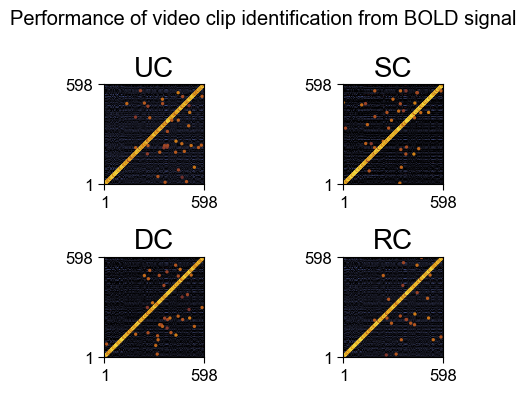

In [19]:
#identification performance

fig = plt.figure(figsize=(5, 4))
fig.suptitle('Performance of video clip identification from BOLD signal')

cmap = plt.get_cmap('cmr.iceburn')   # MPL
models=['UC','SC','DC','RC']
for m in range (len(models)):
    R=sio.loadmat(f"{recunstruction_path}{models[m]}.mat")['R']
    plt.subplot(2,2,m+1) 
    plt.imshow(R, cmap=cmap)
    patches = []

    for i in range(len(R)):
        circ = Circle((i,np.argmax(R[i,:])),10)
        patches.append(circ) 


    colors=np.zeros(len(R))

    for i in range(len(R)):
        colors[i] = R[i,np.argmax(R[i,:])]

    p = PatchCollection(patches, cmap=cmap, alpha=1)
    p.set_array(colors)
    p.set_clim([-1,1])
    plt.subplot(2,2,m+1).add_collection(p)
    plt.gca().invert_yaxis()
    plt.xticks([1,598])
    plt.yticks([1,598])
    plt.title(f'{models[m]}', fontsize=20)
    
plt.tight_layout()